In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [24]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

G = []
C = []
for i in range(10):
    X = M(X_input)
    X = keras.layers.Lambda(
        lambda x,i: K.gradients(x[1][:,i], x[0]),
        output_shape=(28,28,1),
        arguments={'i':i})([X_input, X])
    G_ = keras.Model(X_input, X)
    G_.compile('adam', 'mse')
    G.append(G_)
    X = G_(X_input)
    X = keras.layers.Lambda(
        lambda x: K.gradients(x[1], x[0]),
        output_shape=(28,28,1))([X_input, X])
    C_ = keras.Model(X_input, X)
    C_.compile('adam', 'mse')
    C.append(C_)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [25]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 154us/step - loss: 0.5505 - acc: 0.8601 - val_loss: 0.3350 - val_acc: 0.9123
Epoch 2/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.3245 - acc: 0.9105 - val_loss: 0.2932 - val_acc: 0.9174
Epoch 3/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.2961 - acc: 0.9177 - val_loss: 0.2804 - val_acc: 0.9232
Epoch 4/5
60000/60000 [==============================] - 3s 52us/step - loss: 0.2823 - acc: 0.9208 - val_loss: 0.2729 - val_acc: 0.9242
Epoch 5/5
60000/60000 [==============================] - 3s 50us/step - loss: 0.2740 - acc: 0.9236 - val_loss: 0.2686 - val_acc: 0.9257


In [74]:
def test_plot(test_label, improve_as):
    test_idx = np.random.choice(np.where(ytest == test_label)[0])
    test = xtest[test_idx:test_idx+1]
    pred = M.predict(test)
    grad = G[label].predict(test)
    curv = C[label].predict(test)
    digit = np.argmax(pred[0])
    plt.figure(figsize=(15,5))
    plt.suptitle(f'labeled as {test_label}, predicted as {digit}, improve to be {improve_as}', fontsize=16)
    plt.subplot(1,3,1)
    plt.title('input')
    plt.imshow(test[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title('gradients')
    plt.imshow(grad[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title('curvatures')
    plt.imshow(curv[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.show()

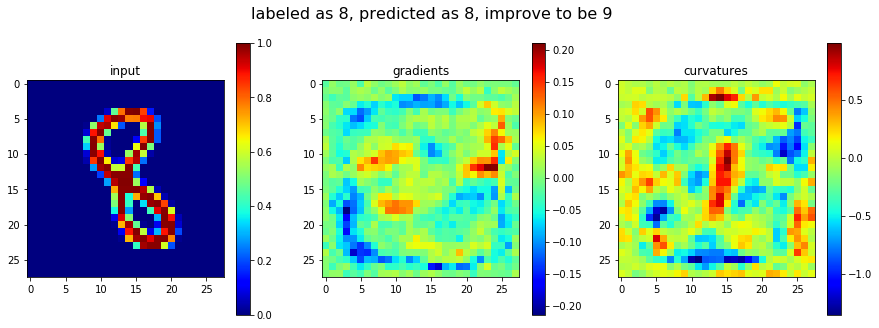

In [80]:
test_plot(8, 9)

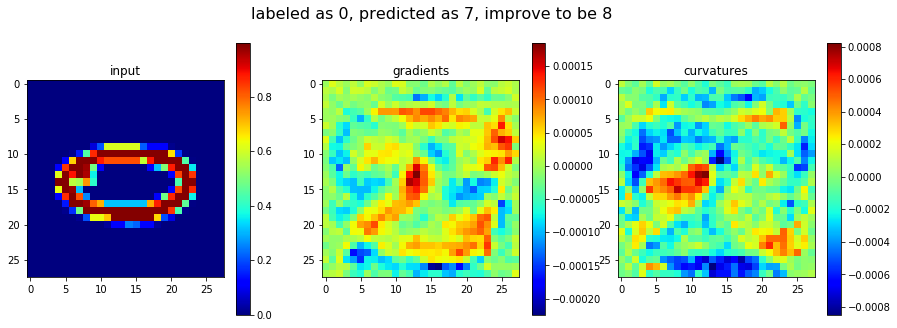

In [82]:
test_plot(0, 8)

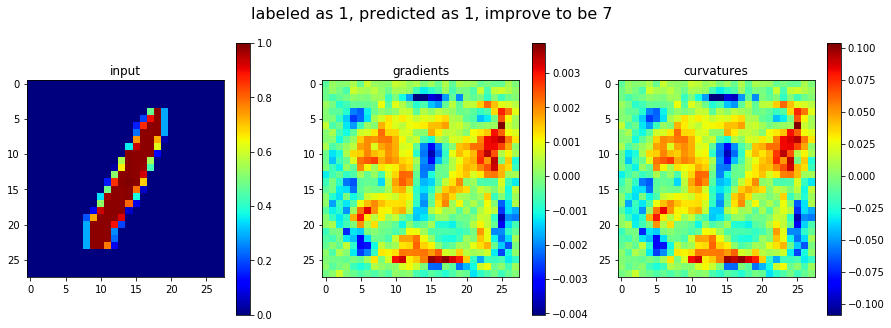

In [92]:
test_plot(1, 7)